# Cloning Quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

![](https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg)

Download the SDSS quasara data

In [1]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data. Does that agree with your expectation? 

(Hint: It shouldn't. But why?) 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

In [2]:
import astropy
astropy.cosmology.Planck18

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform
import timeit

Text(0.5, 1.0, '$z$ Distribution')

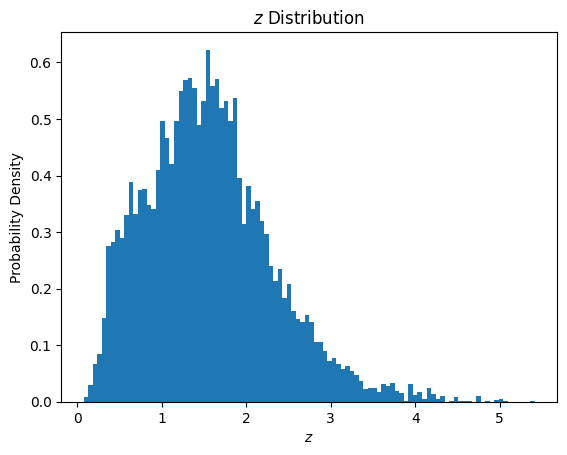

In [4]:
plt.hist(z, 100, density=True)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('$z$ Distribution')

## Functions definition

### Functions for MonteCarlo Sampling

In [18]:
def bin_index(x, bins):
    index=0
    
    for i in range(0, len(bins)-1): 
        if x > bins[i] and x < bins[i+1]:
            index=i
    return index

'''
def Rejection(z, N):
    counts, bins = np.histogram(z, 100, density=True)
    x_i = uniform.rvs(0, np.max(z), N)
    y_i = uniform.rvs(0, np.max(counts), N)
    
    bin_x_i = []
    
    for i in range(len(x_i)):
        bin_x_i.append(bin_index(i, bins))
        
    return x_i[y_i<counts[bin_x_i]], y_i[y_i<counts[bin_x_i]]
'''

def Rejection(z, N):
    counts, bins = np.histogram(z, 100, density=True)
    z_i = []
    p_i = []
    
    for i in range(N):
        current_z   = uniform.rvs(0, np.max(z))
        current_bin = bin_index(current_z, bins)
        current_p   = uniform.rvs(0, np.max(counts))
    
        while current_p < counts[current_bin]:
            z_i.append(current_z)
            p_i.append(current_p)
            current_z   = uniform.rvs(0, np.max(z))
            current_bin = bin_index(current_z, bins)
            current_p   = uniform.rvs(0, np.max(counts))
    
    return z_i, p_i

### Functions for Inverse Transfer Sampling

In [45]:
def quantile(z, N, quant):
    percentiles = [np.percentile(z, quant_i*100) for quant_i in quant]
    
    return percentiles

def inverse_transform(z, N):
    counts, bins = np.histogram(z, 100, density=True)
    
    us = uniform.rvs(0, 1, N)
    x_i = quantile(z, N, us)
    
    return x_i

## MonteCarlo Rejection

In [31]:
z_i, p_i = Rejection(z, 30000)

In [32]:
counts, bins = np.histogram(z, 100, density=True)
np.max(counts)

0.6225033764724289

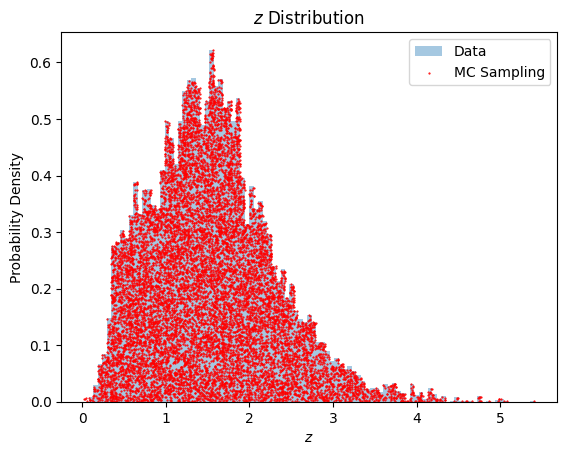

In [33]:
plt.hist(z, 100, density=True, label='Data', alpha=0.4)
plt.scatter(z_i, p_i, marker='o', s=0.3, color='red', label='MC Sampling')
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('$z$ Distribution')
plt.legend()


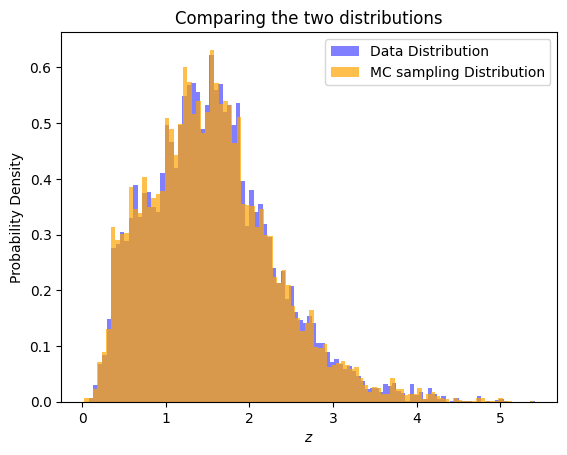

In [44]:
plt.hist(z, 100,   density=True, label='Data Distribution', color='blue', alpha=0.5)
plt.hist(z_i, 100, density=True, label='MC sampling Distribution', color='orange', alpha=0.7)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('Comparing the two distributions')
plt.legend()

## Inverse Cumulative

In [46]:
z_cloned = inverse_transform(z, 30000)

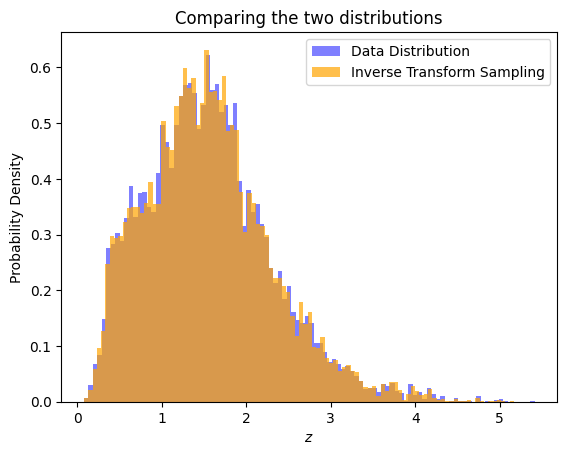

In [52]:
plt.hist(z, 100, histtype='barstacked', density=True, label='Data Distribution', color='blue', alpha=0.5)
plt.hist(z_cloned, 100,  histtype='barstacked', density=True, label='Inverse Transform Sampling', color='orange', alpha=0.7)
plt.xlabel('$z$')
plt.ylabel('Probability Density')
plt.title('Comparing the two distributions')
plt.legend()

## Theoretical Distribution

In [54]:
import astropy.cosmology
astropy.cosmology.Planck15?

In [57]:
z_ls = np.linspace(0, 5)

pdf_ = 4*np.pi* astropy.cosmology.Planck15.differential_comoving_volume(z_ls).value
norm_pdf = pdf_/(4*np.trapz(pdf_, dx=0.01))

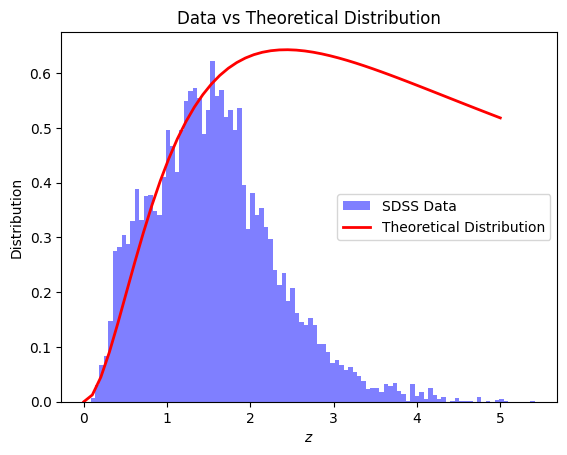

In [63]:
plt.hist(z, 100, density=True, color='blue', alpha=0.5, label='SDSS Data')
plt.plot(z_ls, norm_pdf, color='red', linewidth=2, label='Theoretical Distribution')
plt.xlabel('$z$')
plt.ylabel('Distribution')
plt.title('Data vs Theoretical Distribution')
plt.legend()